In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from numpy.random import default_rng
# from scipy.optimize import root_scalar
# from scipy.interpolate import interp1d
# from scipy.stats import norm, chi2

orig_path="/Users/sebhoof/Research/BHSR/"

rng = default_rng()

sys.path.append("external/bhsr_exclusions_stott/")
from BH_functions import stellar_functions

from py.plotting import *
from py.constants import *
from py.bhsr import *
from py.bosenova import *

set_style()

!mkdir -p figures

### Example plots for solar BH mass and spin samples

m = 14.77 +/- 0.95, a = 1.00 +/- 0.01


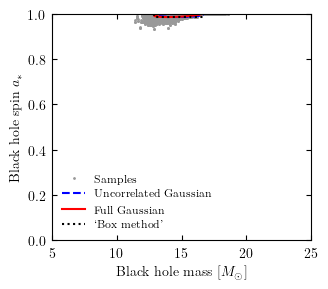

In [2]:
# Cygnus X-1
cygX1_m = []
cygX1_a = []
for i in range(3):
   dat = np.genfromtxt("data/raw/solar/Cygnus_X-1/sp{:d}.txt".format(i+1))
   cygX1_m.append(dat[:,1])
   cygX1_a.append(dat[:,4])
cygX1_m = np.concatenate(cygX1_m)
cygX1_a = np.concatenate(cygX1_a)

plot_m_a(cygX1_m, cygX1_a, label='Cygnus_X-1',)

m = 15.67 +/- 1.49, a = 0.83 +/- 0.06


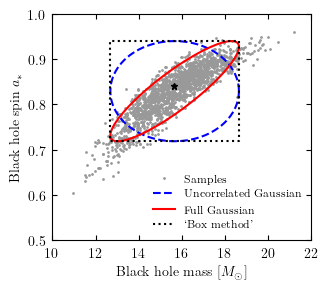

In [3]:
# M33_X-7
data = np.genfromtxt("data/raw/solar/M33_X-7/f3_data_tex.txt")
m33x7_a0 = 0.77 + 0.068
a0 = data[:,0]
m0 = data[:,1]
m33x7_a = -0.2 + (a0-154.560)*(0.1+0.2)/(369.920-154.560) + m33x7_a0
m33x7_m = 12 + (m0-665.600)*(20-12)/(880.960-665.600)

plot_m_a(m33x7_m, m33x7_a, label='M33_X-7', bfit=[15.65, 0.84], xlims=[10,22], ylims=[0.5, 1])

m = 11.10 +/- 1.53, a = 0.60 +/- 0.16


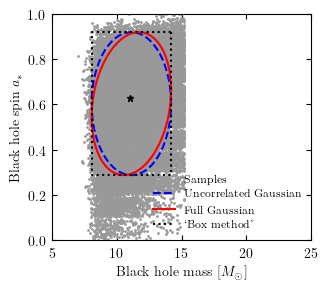

In [4]:
# Nova_Muscae_1991 aka GRS 1124-683
nm_files = !ls {orig_path}bh_data/raw/Nova_Muscae_1991/*npy
nm91_m, nm91_a = [], []
for nmf in nm_files:
   dat = np.load(nmf)
   nm91_m.append(dat[:,1])
   nm91_a.append(dat[:,6])
nm91_m = np.concatenate(nm91_m)
nm91_a = np.concatenate(nm91_a)

plot_m_a(nm91_m, nm91_a, label='GRS_1124-683', bfit=[11.0,0.63])

m = 14266715.28 +/- 3717958.17, a = 0.83 +/- 0.10


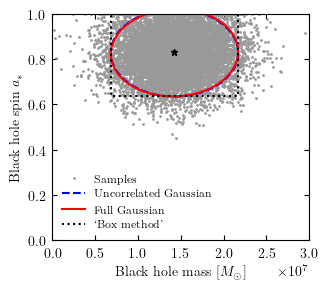

In [5]:
# Some mock data for Mrk 335
# M = 14.2e6 +/- 3.7e6 (https://arxiv.org/pdf/astro-ph/0407299.pdf)
# a = 0.83 +0.09/−0.13 -> +/- 0.1 (https://arxiv.org/pdf/1210.4593.pdf)
mrk33_m = np.maximum(rng.normal(loc=14.2e6, scale=3.7e6, size=10000), 0)
mrk33_a = np.minimum(rng.normal(loc=0.83, scale=0.1, size=10000), 1)

plot_m_a(mrk33_m, mrk33_a, label='MRK_335', bfit=[14.2e6, 0.83], xlims=[0, 30e6])

### Functions for $P_\text{ex}$

In [6]:
ma_test = 7e-12
states = np.array([(i,j,j) for i in range(7) for j in range(1,i)])

# MC exclusion check for M33-X7
n_samples_ref = 100000
astar_ref, lgm_ref = rng.normal(loc=0.84, scale=0.05, size=n_samples_ref), np.log10(rng.normal(loc=15.56, scale=1.45, size=n_samples_ref))

mc_test = []
mc_gammas = []
for m,a in zip(m33x7_m, m33x7_a):
    check = 1
    for s in states:
        gam = GammaSR_nlm(ma_test, m, a, *s)
        if s[0] == 2:
            mc_gammas.append(gam/inv_tSR)
        if gam > inv_tSR:
            check = 0
            break
    mc_test.append(check)
p_ex_mc = 100*(1.0-sum(mc_test)/len(mc_test))
print('P_ex = {:.2f}%'.format(p_ex_mc))

P_ex = 99.95%


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/fractions.py:401: RuntimeWarning: overflow encountered in scalar multiply
  return Fraction(a.numerator * b.numerator, a.denominator * b.denominator)


In [7]:
n_samples_ref = 100000

def get_gaussian_samples(m_mean, m_std, a_mean, a_std, n=n_samples_ref):
    return rng.normal(loc=m_mean, scale=m_std, size=n), rng.normal(loc=a_mean, scale=a_std, size=n)

cygX1_m_gauss, cygX1_a_gauss = get_gaussian_samples(14.8, 1.0, 1.0, (1.0-0.983)/3.0)
nm91_m_gauss, nm91_a_gauss = get_gaussian_samples(11.0, 1.4, 0.63, 0.16)

In [8]:
bh_names = ['Cygnus X-1', 'GRS 1124-683', 'M33 X-7']
bh_indices = {
    'Cygnus X-1': 2,
    'Cyg X-1': 2,
    'GRO J1655-40': 3, 
    'GRS1915+105': 4,
    'M33 X-7': 13,
    'LMC X-1': 11,
}

bh_data = { 'Cygnus X-1': (cygX1_m, cygX1_a), 'GRS 1124-683': (nm91_m, nm91_a), 'M33 X-7': (m33x7_m, m33x7_a) }
bh_gaussian_data = { 'Cygnus X-1': (cygX1_m_gauss, cygX1_a_gauss), 'GRS 1124-683': (nm91_m_gauss, nm91_a_gauss), 'M33 X-7': (10**lgm_ref, astar_ref) }

In [9]:
def mc_integration(mu, data, states):
    temp = []
    for m,a in zip(*data):
        check = 1
        a0 = np.minimum(1, a)
        for s in states:
            if GammaSR_nlm(mu, m, a0, *s) > inv_tSR:
                check = 0
                break
        temp.append(check)
    p_ex = 100.0*(1.0-sum(temp)/len(temp))
    return p_ex

def get_excl_prob(mu, bh_name, states, out=True):
    p_ex_full = mc_integration(mu, bh_data[bh_name], states)
    p_ex_gauss = mc_integration(mu, bh_gaussian_data[bh_name], states)
    if out:
        print('{}: P_ex = {:.2f}% (Full MC), {:.2f}% (Gauss MC)'.format(bh_name, p_ex_full, p_ex_gauss))
    return p_ex_full, p_ex_gauss

def get_excl_prob_matt(lgmu, lginvf, bh_name, states):
    p_ex_matt = []
    for invf in lginvf:
        temp = []
        for m in lgmu:
            try:
                temp.append(100*stellar_functions[bh_indices[bh_name]](m,-invf)[0])
            except:
                temp.append(np.nan)
        p_ex_matt.append(temp)
    return np.array(p_ex_matt)

def get_excl_prob_all(mu, bh_name, states, out=True):
    p_ex_full = mc_integration(mu, bh_data[bh_name], states)
    p_ex_gauss = mc_integration(mu, bh_gaussian_data[bh_name], states)
    try:
        p_ex_matt = 100*stellar_functions[bh_indices[bh_name]](np.log10(mu),18)[0]
    except:
        p_ex_matt = np.nan
    if out:
        print('{}: P_ex = {:.2f}% (Full MC), {:.2f}% (Gauss MC), {:.2f}% (Matt\'s code)'.format(bh_name, p_ex_full, p_ex_gauss, p_ex_matt))
    return p_ex_full, p_ex_gauss, p_ex_matt

table_string = ""
for bh in bh_names:
    p1, p2 = get_excl_prob(ma_test, bh, states)
    table_string += "{} & {:.2f} & {:.2f} \\\\\n".format(bh, p1, p2)
print(table_string)

Cygnus X-1: P_ex = 100.00% (Full MC), 100.00% (Gauss MC)
GRS 1124-683: P_ex = 74.41% (Full MC), 77.48% (Gauss MC)
M33 X-7: P_ex = 99.95% (Full MC), 99.99% (Gauss MC)
Cygnus X-1 & 100.00 & 100.00 \\
GRS 1124-683 & 74.41 & 77.48 \\
M33 X-7 & 99.95 & 99.99 \\



### Exclusions including self-interactions/bosenova
Comparing to results from [arXiv:1411.2263](https://arxiv.org/pdf/1411.2263.pdf)

In [10]:
masha_data = [
    ['M33 X-7', 3e6, 15.56, 1.45, 0.84, 0.1, 0.1],
    ['LMC X-1', 5e6, 10.91, 1.4, 0.92, 0.06, 0.18],
    ['GRO J1655-40', 3.4e8, 6.3, 0.5, 0.72, 0.16, 0.24],
    ['Cyg X-1', 4.8e6, 14.8, 1.0, 1.0, 0.0, 0.005],
    ['GRS1915+105', 4e9, 10.1, 0.6, 1.0, 0.0, 0.025]
]

In [19]:
lgmuvals = np.linspace(-14, -9, 200)
lginvfvals = np.linspace(-20, -10, 100)
grid_x = [[m for m in lgmuvals] for _ in lginvfvals]
grid_y = [[f for _ in lgmuvals] for f in lginvfvals]
states = [(ell+1, ell, ell) for ell in range(1,6)]

grids = [[[is_box_allowed_bosenova(10**m, 10**f, masha_data[i]) for m in lgmuvals] for f in lginvfvals] for i in range(5)]
grids_eq = [[[is_box_allowed_211(10**m, 10**f, masha_data[i], GammaSR_nlm) for m in lgmuvals] for f in lginvfvals] for i in range(5)]

In [20]:
matt_grids = np.array([get_excl_prob_matt(lgmuvals, lginvfvals, masha_data[i][0], states)/100.0 for i in range(5)])

/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_50394/147602531.py:27: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  temp.append(100*stellar_functions[bh_indices[bh_name]](m,-invf)[0])


/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_50394/3149364079.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(grid_x, grid_y, g, levels=[0,1], colors='r', label=r"Baryakhtar+")
/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_50394/3149364079.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(grid_x, grid_y, gm, levels=[0.95], colors='b', label=r"Stott \& Marsh")
/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_50394/3149364079.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(grid_x, grid_y, geq, levels=[0,1], colors='orange', label=r"Using $N_\text{eq}$")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


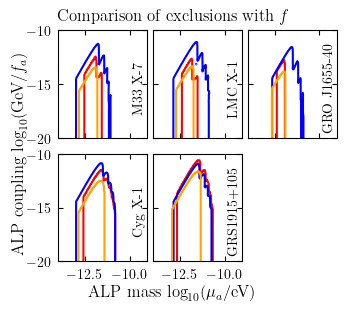

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(3.375,3), sharex=True, sharey=True)
for g,geq,gm,ax,m in zip(grids,grids_eq,matt_grids,axes.flat,masha_data):
    #ax.contourf(grid_x, grid_y, g)
    ax.contour(grid_x, grid_y, g, levels=[0,1], colors='r', label=r"Baryakhtar+")
    ax.contour(grid_x, grid_y, gm, levels=[0.95], colors='b', label=r"Stott \& Marsh")
    ax.contour(grid_x, grid_y, geq, levels=[0,1], colors='orange', label=r"Using $N_\text{eq}$")
    ax.text(-9.5, -15.5, m[0], ha='center', va='center', rotation=90, c='k')
    ax.set_xlim([-14,-9])
    ax.set_ylim([-20,-10])
axes[-1,-1].axis('off')
axes[-1,-1].legend()
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.supxlabel(r"ALP mass $\log_{10}(\mu_a/\text{eV})$")
fig.supylabel(r"ALP coupling $\log_{10}(\text{GeV}/f_a)$")
fig.suptitle(r"Comparison of exclusions with $f$")
fig.tight_layout(pad=0.25)
#fig.savefig("figures/reproduced_exclusions_2d.pdf", backend='pgf')
plt.show()

In [15]:
# Make comparison for M33-X7

lgmrange = np.arange(-14, -10, 0.05)

pex_m33x7 = [get_excl_prob(10**lgm, 'M33 X-7', states, out=False) for lgm in tqdm(lgmrange)]
pex_m33x7 = np.array(pex_m33x7)
pex_m33x7_masha = np.array([is_box_allowed_bosenova(10**lgm, 1e-18, masha_data[0]) for lgm in lgmrange])

  0%|          | 0/80 [00:00<?, ?it/s]

In [16]:
from scipy.stats import chi2
from scipy.interpolate import interp1d 
from scipy.integrate import quad

#print(chi2.ppf(0.9545, df=1))
marg_ll = interp1d(lgmrange, 1-0.01*pex_m33x7[:,0])
post_norm, post_norm_err = quad(lambda x: marg_ll(x), -13.9, -10.1)
print(post_norm, post_norm_err)

1.8710300171996157 5.282869147937852e-05


/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_50394/1607901714.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  post_norm, post_norm_err = quad(lambda x: marg_ll(x), -13.9, -10.1)


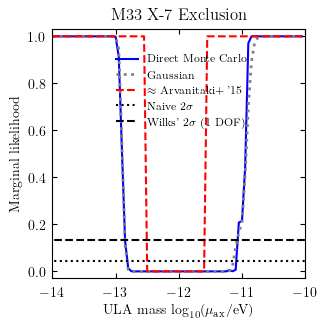

In [17]:
"""
fig, ax = plt.subplots()
ax.plot(lgmrange, 0.01*(pex_m33x7[:,0]-pex_m33x7[:,2]), 'b-', label='Full')
ax.plot(lgmrange, 0.01*(pex_m33x7[:,1]-pex_m33x7[:,2]), 'r--', label='Gaussian')
ax.plot(lgmrange, pex_m33x7_masha-0.01*pex_m33x7[:,2], 'k:', label="Masha++")
#ax.plot(lgmrange, pex_m33x7[:,2]/100 - pex_matt[:,1], 'orange', label=r"Matt's code")
ax.set_title('M33-X7')
ax.set_xlabel(r'ULA mass $\mu_\text{ax}$')
ax.set_ylabel("Excl. prob. - Matt\'s result")
ax.set_ylim([-1,1])
ax.legend()
plt.show()
""";

fig, ax = plt.subplots(figsize=(3.375,3.375))

#ax.plot(lgmrange, 1-0.01*pex_m33x7[:,2], c='purple', ls='--', label=r"Stott + Marsh '18")
ax.plot(lgmrange, 1-0.01*pex_m33x7[:,0], 'b-', label="Direct Monte Carlo")
ax.plot(lgmrange, 1-0.01*pex_m33x7[:,1], c='grey', ls=':', lw=2, label="Gaussian")
ax.plot(lgmrange, 1-pex_m33x7_masha, 'r--', label=r"$\approx$ Arvanitaki+ '15")
ax.plot([-16,-8], 2*[1-0.9545], 'k:', label=r"Naive $2\sigma$")
ax.plot([-16,-8], 2*[np.exp(-0.5*4)], 'k--', label=r"Wilks' $2\sigma$ (1 DOF)")

ax.set_title('M33 X-7 Exclusion')
ax.set_xlabel(r"ULA mass $\log_{10}(\mu_\text{ax}/\text{eV})$")
ax.set_ylabel("Marginal likelihood")
ax.set_xlim([-14,-10])
ax.set_ylim([-0.03,1.03])
ax.legend(loc='center', bbox_to_anchor=(0.51,0.75))
fig.tight_layout()
fig.savefig("figures/marginal_likelihood.pdf", backend='pgf')
plt.show()